# ComScore data: Explore demographics


ACS 5-YEAR estimates are used for comparison.

[Here](https://api.census.gov/data/2017/acs/acs5/profile/variables.html) is the resource for variables.

In [440]:

import joblib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

from census import Census
import us
from pyzipcode import ZipCodeDatabase


YEAR = 2017 
c = Census("14a343e581b5dd1df551f4cd87f31aede50ec908", year=YEAR)
demographics_fpath = '../data/comscore/{year}/demographics.csv'.format(year=YEAR)

In [441]:
# Plot colors and things
c_acs = 'black'
c_comscore = 'purple'

Reads in the ComScore demographic data and drops rows for machine IDs where the U.S. zipcode or state cannot be identified.

In [442]:
def get_state_fips(zipcode, err=False):
    """returns a state FIPS for the state with given zipcide.
    
    if it can't find the zip code, return np.nan if err=False.
    
    parameters
    ----------
    err: boolean. True if function should raise a ValueError if it can't find a zip code. False by default.
    """
    
    zcdb = ZipCodeDatabase()
    if zipcode not in zcdb:
        if err:
            raise ValueError("Zip code not found")
        else:
            return np.nan
    zipcode = zcdb[zipcode]
    state = us.states.lookup(zipcode.state)
    return state.fips

In [199]:
# drops machine ID since it is not needed for this data exploration
# safer way to show data
demo_df = (pd.read_csv(demographics_fpath, dtype={'zip_code': str})
           .drop('machine_id', axis=1)
           .replace({99:np.nan}))
rows = len(demo_df)
print('%s rows before' % rows)
demo_df.head(3)

93808 rows before


,hoh_most_education,census_region,household_size,hoh_oldest_age,household_income,children,racial_background,connection_speed,country_of_origin,zip_code
0,NaN,4.0,5.0,8.0,16.0,0.0,1.0,1.0,0.0,98611
1,3.0,4.0,3.0,8.0,14.0,0.0,1.0,1.0,0.0,80910
2,4.0,1.0,3.0,11.0,16.0,1.0,1.0,1.0,0.0,07076


In [200]:
demo_df = (demo_df
           .dropna(subset=['zip_code'])
           # make sure zips are zip5
           .assign(zip_code=lambda x: x.zip_code.apply(lambda z: '0' + z if len(z) < 5 else z))
           # get state fips code for each zip
           .assign(state_fips=lambda x: x.zip_code.apply(lambda z: get_state_fips(z)))
           .dropna(subset=['state_fips'])
           .assign(state=lambda x: x.state_fips.apply(lambda s: us.states.lookup(s).abbr))
          )
print('%s rows after' % len(demo_df))
print('dropped %s rows' % (rows - len(demo_df))) # 

92884 rows after
dropped 924 rows


In [201]:
demo_df.head()

,hoh_most_education,census_region,household_size,hoh_oldest_age,household_income,children,racial_background,connection_speed,country_of_origin,zip_code,state_fips,state
0,NaN,4.0,5.0,8.0,16.0,0.0,1.0,1.0,0.0,98611,53,WA
1,3.0,4.0,3.0,8.0,14.0,0.0,1.0,1.0,0.0,80910,08,CO
2,4.0,1.0,3.0,11.0,16.0,1.0,1.0,1.0,0.0,07076,34,NJ
3,3.0,2.0,1.0,9.0,16.0,0.0,1.0,1.0,0.0,62554,17,IL
5,1.0,4.0,3.0,7.0,12.0,0.0,1.0,1.0,1.0,93436,06,CA


household income variable probably coded with extra 1
11.0    21189
13.0    15970
12.0    15895
16.0    11224
15.0    10984
14.0     8666
18.0     4703
17.0     4253
Name: household_income, dtype: int64


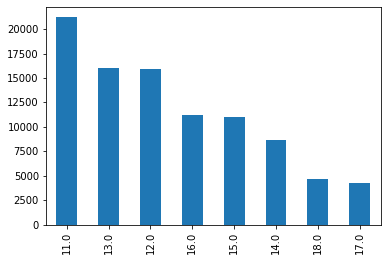

In [202]:
# What is wrong with household income?
print('household income variable probably coded with extra 1')
print(demo_df.household_income.value_counts())
_ = demo_df.household_income.value_counts().plot.bar()

In [203]:
demo_df.household_income = demo_df.household_income % 10
demo_df.head()

,hoh_most_education,census_region,household_size,hoh_oldest_age,household_income,children,racial_background,connection_speed,country_of_origin,zip_code,state_fips,state
0,NaN,4.0,5.0,8.0,6.0,0.0,1.0,1.0,0.0,98611,53,WA
1,3.0,4.0,3.0,8.0,4.0,0.0,1.0,1.0,0.0,80910,08,CO
2,4.0,1.0,3.0,11.0,6.0,1.0,1.0,1.0,0.0,07076,34,NJ
3,3.0,2.0,1.0,9.0,6.0,0.0,1.0,1.0,0.0,62554,17,IL
5,1.0,4.0,3.0,7.0,2.0,0.0,1.0,1.0,1.0,93436,06,CA


## Retrieving census data

Let's test getting relevant census data. I went [here](https://api.census.gov/data/2017/acs/acs5/profile/variables.html) and looked up relevant variables and just hand-coded them below. I added a mapping to the relevant comscore coding.

TODO: 

- [x] Add additional codes for other variables
- [ ] verify we did this right

In [387]:
census_mapping = pd.DataFrame([
    # education level. 
    # Note discrepancy: ACS is for individuals > 25 yrs
    # vs ComScore data for household
    ['DP02_0064E', 4, 'bachelors degree', 'hoh_most_education'],
    ['DP02_0061E', 1, 'high school graduate', 'hoh_most_education'],
    ['DP02_0065E', 5, 'graduate degree', 'hoh_most_education'],
    ['DP02_0062E', 2, 'some college, no degree', 'hoh_most_education'],
    ['DP02_0063E', 3, 'associates degree', 'hoh_most_education'],
    # two rows for comscore-coded zero. Should sum for comparison.
    ['DP02_0060E', 0, '9-12 grade no diploma', 'hoh_most_education'],
    ['DP02_0059E', 0, 'less than 9th grade', 'hoh_most_education'],
    # Racial Background
    # ComScore uses 1,2,3,5
    # TODO / Question: is non-hispanic encoding right one to use?
    # e.g. instead use DP05_0037PE
    ['DP05_0077E', 1, 'non-hispanic white', 'racial_background'], 
    ['DP05_0078E', 2, 'non-hispanic black', 'racial_background'],
    ['DP05_0080E', 3, 'non-hispanic asian', 'racial_background'],
    # ComScore 5: other
    
    # Country of origin: hispanic / non-hispanic
    ['DP05_0071E', 1, 'hispanic', 'country_of_origin'],
    
    # Household income
    # ComScore: 1 Less than 15k 2 15k-24.999k 3 25k-34.999k 
    # 4 35k-49.999k 5 50k-74.999k 6 75k-99.999k 7 100k+
    # two rows for ComScore-coded 1
    ['DP03_0052E', 1, 'Less than $10,000', 'household_income'],
    ['DP03_0053E', 1, '\$10,000 to $14,999', 'household_income'],
    ['DP03_0054E', 2, '\$15,000 to $24,999', 'household_income'],
    ['DP03_0055E', 3, '\$25,000 to $34,999', 'household_income'],
    ['DP03_0056E', 4, '\$35,000 to $49,999', 'household_income'],
    ['DP03_0057E', 5, '\$50,000 to $74,999', 'household_income'],
    ['DP03_0058E', 6, '\$75,000 to $99,999', 'household_income'],
    ['DP03_0059E', 7, '\$100,000 to $149,999', 'household_income'],
    ['DP03_0060E', 7, '\$150,000 to $199,999', 'household_income'],
    ['DP03_0061E', 7, '\$200,000 or more', 'household_income'],
    
], columns=['census_code', 'comscore_code', 'description', 'comscore_column'])

In [388]:
census_mapping

,census_code,comscore_code,description,comscore_column
0,DP02_0064E,4,bachelors degree,hoh_most_education
1,DP02_0061E,1,high school graduate,hoh_most_education
2,DP02_0065E,5,graduate degree,hoh_most_education
3,DP02_0062E,2,"some college, no degree",hoh_most_education
4,DP02_0063E,3,associates degree,hoh_most_education
5,DP02_0060E,0,9-12 grade no diploma,hoh_most_education
6,DP02_0059E,0,less than 9th grade,hoh_most_education
7,DP05_0077E,1,non-hispanic white,racial_background
8,DP05_0078E,2,non-hispanic black,racial_background
9,DP05_0080E,3,non-hispanic asian,racial_background


In [389]:
census_vars = list(census_mapping.census_code.values)

### for US level

In [412]:
us_census_data = c.acs5dp.us(census_vars) 
us_census_df = pd.DataFrame(
    us_census_data
).drop('us', axis=1)
us_census_df['population estimate'] = c.acs5dp.us(['DP05_0070E'])[0]['DP05_0070E']
us_census_df.head()

,DP02_0064E,DP02_0061E,DP02_0065E,DP02_0062E,DP02_0063E,DP02_0060E,DP02_0059E,DP05_0077E,DP05_0078E,DP05_0080E,...,DP03_0053E,DP03_0054E,DP03_0055E,DP03_0056E,DP03_0057E,DP03_0058E,DP03_0059E,DP03_0060E,DP03_0061E,population estimate
0,41377068.0,59093612.0,25510535.0,44935834.0,17917481.0,15677560.0,11759554.0,197277789.0,39445495.0,16989540.0,...,5768114.0,11637905.0,11330288.0,15412493.0,21000314.0,14636046.0,16701857.0,6931136.0,7465517.0,321004407.0


### for states

Retrieving census data by states 

instead of zip codes because:
- ComScore data by zip codes is sparse 
- Therefore need to aggregate by state anyhow
- Data is retrieved via API calls; So this is faster b/c fewer states than zipcodes

Data is also retrieved by state further below.

In [391]:
def get_census_data_for_state(state_fips, var_names, year=YEAR):
    """
    retrieves census variables for a given STATE and year from the ACS
    
    parameters
    ----------
    state_fips: string. state FIPs to search for
    var_names: list. list of variable names from the ACS.
    
    returns
    -------
    A dict with a key for each var in var_names where the value
    is the corresponding value for the zipcode, plus a key for `state` with 
    the corresponding FIPS code and a key for `zip code tabulation area` 
    that parrots the zip.
    
    example
    -------
    >>> get_census_data_for_state('25', ['DP05_0080PE'])
    """
    try:
        result = c.acs5dp.state(
            var_names,
            state_fips,
            year=year)[0]
        return result
    except Exception as e:
        print("Couldn't retrieve census data for state {}: {}".format(state_fips, e))
        return None

r = demo_df.iloc[0]

In [392]:
states_fips = list(demo_df.state_fips.unique())
print(len(states_fips))
# states_fips

51


In [393]:
state_census_data = [get_census_data_for_state(s, census_vars) for s in states_fips]

In [394]:
state_census_df = pd.DataFrame(
    [s for s in state_census_data if s is not None]
).rename(columns={'state':'state_fips'}).set_index('state_fips')
state_census_df.head()

,DP02_0064E,DP02_0061E,DP02_0065E,DP02_0062E,DP02_0063E,DP02_0060E,DP02_0059E,DP05_0077E,DP05_0078E,DP05_0080E,...,DP03_0052E,DP03_0053E,DP03_0054E,DP03_0055E,DP03_0056E,DP03_0057E,DP03_0058E,DP03_0059E,DP03_0060E,DP03_0061E
state_fips,,,,,,,,,,,,,,,,,,,,,
53,1064440.0,1101904.0,622908.0,1174696.0,483549.0,260358.0,188200.0,5001482.0,251603.0,573457.0,...,155404.0,102595.0,217004.0,228787.0,335962.0,497935.0,372647.0,450796.0,194700.0,199867.0
08,909794.0,791683.0,536679.0,798224.0,307078.0,191957.0,133062.0,3731976.0,209885.0,161733.0,...,111732.0,76241.0,165617.0,178164.0,261592.0,377542.0,281673.0,337068.0,146006.0,146896.0
34,1439971.0,1722597.0,907865.0,1026060.0,400424.0,351184.0,315598.0,5023606.0,1136347.0,838872.0,...,170840.0,113188.0,247138.0,232026.0,322263.0,490325.0,390092.0,556938.0,296256.0,380045.0
17,1776326.0,2281524.0,1122258.0,1812247.0,682300.0,544799.0,446625.0,7955484.0,1806398.0,666890.0,...,331315.0,204278.0,446453.0,425803.0,593198.0,836760.0,613614.0,724960.0,311141.0,330930.0
06,5291984.0,5345542.0,3161747.0,5586071.0,2021944.0,2033160.0,2510370.0,14777594.0,2161459.0,5427928.0,...,694945.0,604666.0,1105197.0,1063551.0,1465836.0,2095531.0,1568843.0,2025327.0,1008388.0,1255844.0


Add in total population

Question: Are ACS total population estimates consistent across survey questions?

Answer: Yes.

But keep in mind that some questions are for all individuals, some for households, some for individuals > 25 years... etc

In [395]:
# Estimate!!HISPANIC OR LATINO AND RACE!!Total population
# DP05_0070E
print(c.acs5dp.state(['DP05_0070E'], '25', year=YEAR))
# Estimate!!RACE!!Total population
# DP05_0033E
print(c.acs5dp.state(['DP05_0033E'], '25', year=YEAR))

[{'DP05_0070E': 6789319.0, 'state': '25'}]
[{'DP05_0033E': 6789319.0, 'state': '25'}]


In [396]:
def get_pop_estimate_for_state(state_fips, year=YEAR):
    data = get_census_data_for_state(state_fips, ['DP05_0070E'])['DP05_0070E']
    return data

In [397]:
state_census_df['population estimate'] = state_census_df.index.map(get_pop_estimate_for_state)

In [398]:
state_census_df.head()

,DP02_0064E,DP02_0061E,DP02_0065E,DP02_0062E,DP02_0063E,DP02_0060E,DP02_0059E,DP05_0077E,DP05_0078E,DP05_0080E,...,DP03_0053E,DP03_0054E,DP03_0055E,DP03_0056E,DP03_0057E,DP03_0058E,DP03_0059E,DP03_0060E,DP03_0061E,population estimate
state_fips,,,,,,,,,,,,,,,,,,,,,
53,1064440.0,1101904.0,622908.0,1174696.0,483549.0,260358.0,188200.0,5001482.0,251603.0,573457.0,...,102595.0,217004.0,228787.0,335962.0,497935.0,372647.0,450796.0,194700.0,199867.0,7169967.0
08,909794.0,791683.0,536679.0,798224.0,307078.0,191957.0,133062.0,3731976.0,209885.0,161733.0,...,76241.0,165617.0,178164.0,261592.0,377542.0,281673.0,337068.0,146006.0,146896.0,5436519.0
34,1439971.0,1722597.0,907865.0,1026060.0,400424.0,351184.0,315598.0,5023606.0,1136347.0,838872.0,...,113188.0,247138.0,232026.0,322263.0,490325.0,390092.0,556938.0,296256.0,380045.0,8960161.0
17,1776326.0,2281524.0,1122258.0,1812247.0,682300.0,544799.0,446625.0,7955484.0,1806398.0,666890.0,...,204278.0,446453.0,425803.0,593198.0,836760.0,613614.0,724960.0,311141.0,330930.0,12854526.0
06,5291984.0,5345542.0,3161747.0,5586071.0,2021944.0,2033160.0,2510370.0,14777594.0,2161459.0,5427928.0,...,604666.0,1105197.0,1063551.0,1465836.0,2095531.0,1568843.0,2025327.0,1008388.0,1255844.0,38982847.0


In [399]:
state_census_df['state_abbr'] = (state_census_df.index.map(str)
    .map(lambda s: '0'+s if len(s) < 2 else s)
    .map(lambda s: us.states.lookup(s).abbr)
)

In [400]:
state_census_df.head()

,DP02_0064E,DP02_0061E,DP02_0065E,DP02_0062E,DP02_0063E,DP02_0060E,DP02_0059E,DP05_0077E,DP05_0078E,DP05_0080E,...,DP03_0054E,DP03_0055E,DP03_0056E,DP03_0057E,DP03_0058E,DP03_0059E,DP03_0060E,DP03_0061E,population estimate,state_abbr
state_fips,,,,,,,,,,,,,,,,,,,,,
53,1064440.0,1101904.0,622908.0,1174696.0,483549.0,260358.0,188200.0,5001482.0,251603.0,573457.0,...,217004.0,228787.0,335962.0,497935.0,372647.0,450796.0,194700.0,199867.0,7169967.0,WA
08,909794.0,791683.0,536679.0,798224.0,307078.0,191957.0,133062.0,3731976.0,209885.0,161733.0,...,165617.0,178164.0,261592.0,377542.0,281673.0,337068.0,146006.0,146896.0,5436519.0,CO
34,1439971.0,1722597.0,907865.0,1026060.0,400424.0,351184.0,315598.0,5023606.0,1136347.0,838872.0,...,247138.0,232026.0,322263.0,490325.0,390092.0,556938.0,296256.0,380045.0,8960161.0,NJ
17,1776326.0,2281524.0,1122258.0,1812247.0,682300.0,544799.0,446625.0,7955484.0,1806398.0,666890.0,...,446453.0,425803.0,593198.0,836760.0,613614.0,724960.0,311141.0,330930.0,12854526.0,IL
06,5291984.0,5345542.0,3161747.0,5586071.0,2021944.0,2033160.0,2510370.0,14777594.0,2161459.0,5427928.0,...,1105197.0,1063551.0,1465836.0,2095531.0,1568843.0,2025327.0,1008388.0,1255844.0,38982847.0,CA


In [401]:
state_census_df.reset_index().to_csv("../output/state_census.csv", index=False)

script re-entry point

In [402]:
state_census_df = pd.read_csv("../output/state_census.csv", dtype={'state_fips': str}).set_index('state_fips')
state_census_df.head()

,DP02_0064E,DP02_0061E,DP02_0065E,DP02_0062E,DP02_0063E,DP02_0060E,DP02_0059E,DP05_0077E,DP05_0078E,DP05_0080E,...,DP03_0054E,DP03_0055E,DP03_0056E,DP03_0057E,DP03_0058E,DP03_0059E,DP03_0060E,DP03_0061E,population estimate,state_abbr
state_fips,,,,,,,,,,,,,,,,,,,,,
53,1064440.0,1101904.0,622908.0,1174696.0,483549.0,260358.0,188200.0,5001482.0,251603.0,573457.0,...,217004.0,228787.0,335962.0,497935.0,372647.0,450796.0,194700.0,199867.0,7169967.0,WA
08,909794.0,791683.0,536679.0,798224.0,307078.0,191957.0,133062.0,3731976.0,209885.0,161733.0,...,165617.0,178164.0,261592.0,377542.0,281673.0,337068.0,146006.0,146896.0,5436519.0,CO
34,1439971.0,1722597.0,907865.0,1026060.0,400424.0,351184.0,315598.0,5023606.0,1136347.0,838872.0,...,247138.0,232026.0,322263.0,490325.0,390092.0,556938.0,296256.0,380045.0,8960161.0,NJ
17,1776326.0,2281524.0,1122258.0,1812247.0,682300.0,544799.0,446625.0,7955484.0,1806398.0,666890.0,...,446453.0,425803.0,593198.0,836760.0,613614.0,724960.0,311141.0,330930.0,12854526.0,IL
06,5291984.0,5345542.0,3161747.0,5586071.0,2021944.0,2033160.0,2510370.0,14777594.0,2161459.0,5427928.0,...,1105197.0,1063551.0,1465836.0,2095531.0,1568843.0,2025327.0,1008388.0,1255844.0,38982847.0,CA


### for zip codes

So far we don't need this. but here we have it.

In [16]:
def get_census_data_for_zip(zipcode, var_names, year=2017):
    """retrieves census variables for a given zipcode and year from the ACS
    
    parameters
    ----------
    zipcode: string. zip code to search for
    var_names: list. list of variable names from the ACS.
    
    returns
    -------
    A dict with a key for each var in var_names where the value
    is the corresponding value for the zipcode, plus a key for `state` with 
    the corresponding FIPS code and a key for `zip code tabulation area` 
    that parrots the zip.
    
    example
    -------
    >>> get_census_data_for_zip('02130', ['DP05_0080PE'])
    """
    state_fips = get_state_fips(zipcode)
    if not state_fips:
        return None
    try:
        result = c.acs5dp.state_zipcode(
            var_names,
            state_fips,
            zipcode,
            year=year)[0]
        return result
    except Exception as e:
        print("Couldn't retrieve census data for zip {}: {}".format(zipcode, e))
        return None

r = demo_df.iloc[0]
zips = list(set(demo_df.zip_code))
zip_demos = c.acs5dp.state_zipcode(list(census_mapping.census_code.values), r.state_fips, r.zip_code, year=2017)

It takes a while, so run in parallel (way faster)

In [24]:
from joblib import Parallel, delayed
N_CORES = 24

%time zip_census_data = Parallel(n_jobs=N_CORES)(delayed(get_census_data_for_zip)(zip, census_vars) for zip in zips)
zip_census_df = pd.DataFrame([z for z in zip_census_data if z is not None])

%mkdir ../output
zip_census_df.rename(
    columns={'zip code tabulation area': 'zip_code'}
).to_csv("../output/zip_census.csv", index=False)

CPU times: user 1min 20s, sys: 4.15 s, total: 1min 24s
Wall time: 17min 58s


script re-entry point

In [36]:
zip_census_df = pd.read_csv("../output/zip_census.csv").set_index('zip_code')
zip_census_df.head()

,DP02_0064PE,DP02_0061PE,DP02_0065PE,DP02_0062PE,DP02_0063PE,DP02_0060PE,DP02_0059PE,DP05_0077PE,DP05_0078PE,DP05_0080PE,state
zip_code,,,,,,,,,,,
33948,12.9,33.9,10.6,25.5,8.7,5.7,2.9,81.5,5.8,1.9,12
30668,5.6,50.8,2.3,15.9,4.3,15.4,5.6,70.4,27.4,0.0,13
29302,25.1,20.9,20.4,15.1,8.7,7.3,2.4,74.2,18.2,4.3,45
92315,15.1,23.9,8.2,27.9,14.6,6.7,3.6,67.3,1.1,1.0,6
32404,8.6,34.5,5.0,29.3,10.7,9.5,2.4,75.1,12.1,3.1,12


In [38]:
zip_census_df.state.nunique()

51

In [70]:
len(zip_census_df)

16993

## Compare aggregate statistics

Look at total population.

Look at demographic breakdowns by comparing percent estimates.

When computing percent estimates from ComScore data, do separately for each demographic category and use total as the sum that reported data for that category.
This is because some rows are missing data for some categories, so totals are different.

### State populations totals

In [403]:
state_pop_df = (
    state_census_df[['population estimate','state_abbr']]
    .assign(comscore_count=lambda x: x.index.map(demo_df.state_fips.value_counts()))
).sort_values('population estimate', ascending=False)
state_pop_df.head()

,population estimate,state_abbr,comscore_count
state_fips,,,
06,38982847.0,CA,9285
48,27419612.0,TX,8028
12,20278447.0,FL,7110
36,19798228.0,NY,5798
17,12854526.0,IL,3670


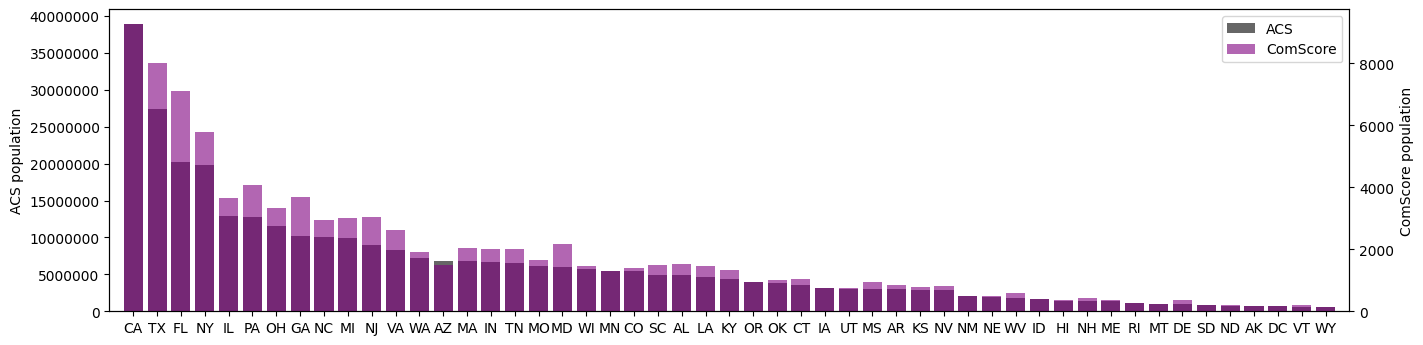

In [404]:
fig,ax = plt.subplots(1,1,figsize=(16,4), dpi=100)
ax.bar(
    state_pop_df.state_abbr, state_pop_df['population estimate'],
    color=c_acs, alpha=0.6, label='ACS'
)
ax.ticklabel_format(useOffset=False, axis='y', style='plain')
ax.set_xlim(-1, len(state_pop_df))
ax.set_ylabel('ACS population')
ax2 = ax.twinx()
ax2.bar(
    state_pop_df.state_abbr, state_pop_df['comscore_count'],
    color=c_comscore, alpha=0.6, label='ComScore'
)
ax2.set_ylabel('ComScore population')
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
_ = ax2.legend(lines + lines2, labels + labels2, loc=0)

In [405]:
from scipy.stats import pearsonr

In [406]:
r, pvalue = pearsonr(state_pop_df['comscore_count'], state_pop_df['population estimate'])
r, pvalue

(0.9829504951737682, 1.054087082875075e-37)

## Income

In [427]:
census_incomes = census_mapping[census_mapping.comscore_column == 'household_income'][
    ['census_code','comscore_code']
].set_index('census_code')
census_incomes['count'] = us_census_df.transpose()
census_incomes

,comscore_code,count
census_code,,
DP03_0052E,1,7942251.0
DP03_0053E,1,5768114.0
DP03_0054E,2,11637905.0
DP03_0055E,3,11330288.0
DP03_0056E,4,15412493.0
DP03_0057E,5,21000314.0
DP03_0058E,6,14636046.0
DP03_0059E,7,16701857.0
DP03_0060E,7,6931136.0


In [439]:
# WHAT does 8 mean? We don't know and we drop it
demo_df['household_income'].value_counts()

1.0    21189
3.0    15970
2.0    15895
6.0    11224
5.0    10984
4.0     8666
8.0     4703
7.0     4253
Name: household_income, dtype: int64

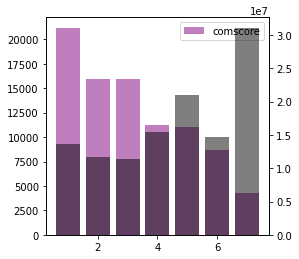

In [489]:
fig,ax = plt.subplots(1,1,figsize=(4,4))
labels = list(range(1,8))
ax.bar(labels, demo_df['household_income'].value_counts().drop(8).values, 
       label='comscore',
       alpha=0.5, color=c_comscore)
ax2 = ax.twinx()
ax2.bar(labels, census_incomes.groupby('comscore_code').agg('sum')['count'], 
       label='ACS',
       alpha=0.5, color=c_acs)
_ = ax.legend()

## State census incomes

In [470]:
state_census_incomes = state_census_df.transpose().loc[census_incomes.index]
state_census_incomes['comscore code'] = state_census_incomes.index.map(census_incomes['comscore_code'])
state_census_incomes = state_census_incomes.groupby('comscore code').agg('sum')
state_census_incomes

state_fips,53,08,34,17,06,49,45,42,51,25,...,44,54,10,16,41,56,38,50,33,11
comscore code,,,,,,,,,,,,,,,,,,,,,
1,257999.0,187973.0,284028.0,535593.0,1299611.0,73030.0,261808.0,576106.0,288796.0,269677.0,...,52033.0,116105.0,33831.0,71692.0,176879.0,21103.0,31964.0,27479.0,39091.0,39079.0
2,217004.0,165617.0,247138.0,446453.0,1105197.0,69801.0,214556.0,502208.0,240698.0,203309.0,...,38490.0,98901.0,28737.0,64685.0,156932.0,21785.0,27190.0,25810.0,40350.0,19346.0
3,228787.0,178164.0,232026.0,425803.0,1063551.0,79338.0,210196.0,483144.0,246542.0,186707.0,...,35651.0,85131.0,32426.0,68175.0,157131.0,21695.0,28707.0,24931.0,42221.0,17893.0
4,335962.0,261592.0,322263.0,593198.0,1465836.0,122029.0,268161.0,653515.0,361936.0,255677.0,...,47817.0,108061.0,45507.0,93091.0,212471.0,30505.0,40668.0,33798.0,60684.0,22915.0
5,497935.0,377542.0,490325.0,836760.0,2095531.0,194204.0,342557.0,908240.0,531135.0,390219.0,...,67672.0,132714.0,64740.0,122368.0,291503.0,43455.0,56924.0,49311.0,94712.0,36395.0
6,372647.0,281673.0,390092.0,613614.0,1568843.0,142832.0,220018.0,635089.0,398836.0,317494.0,...,53331.0,80683.0,48383.0,75052.0,202965.0,32555.0,43906.0,36006.0,74488.0,29781.0
7,845363.0,629970.0,1233239.0,1367031.0,4289559.0,257131.0,354011.0,1249140.0,1037693.0,962632.0,...,117034.0,116076.0,98733.0,114061.0,373750.0,59139.0,82166.0,61200.0,175164.0,112576.0


household income for ComScore data


/Users/aberke/projects/floc-analysis/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


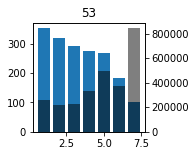

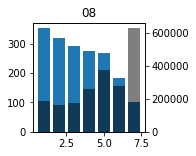

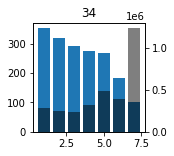

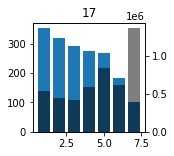

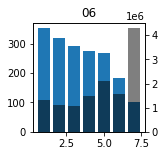

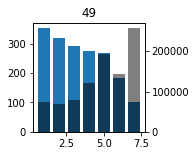

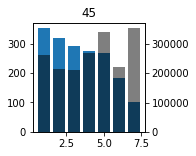

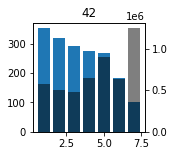

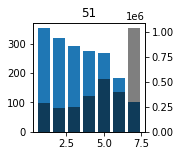

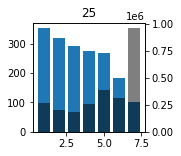

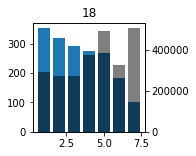

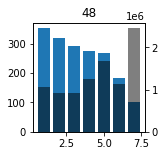

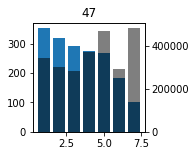

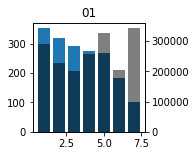

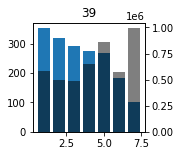

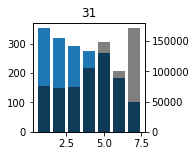

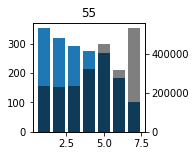

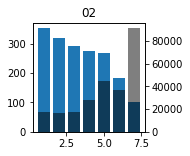

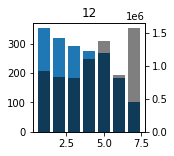

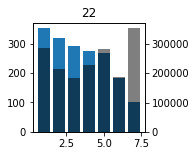

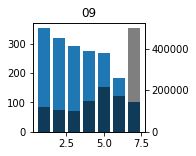

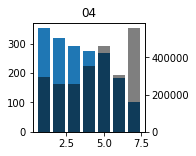

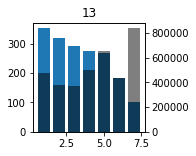

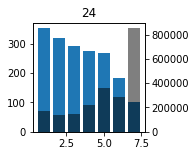

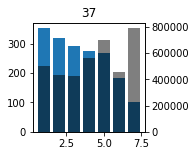

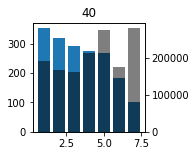

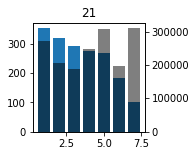

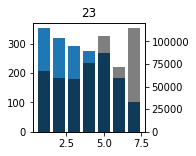

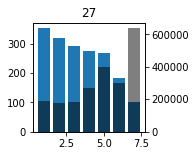

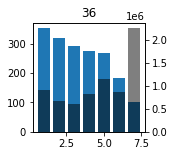

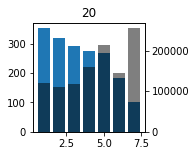

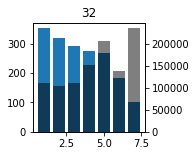

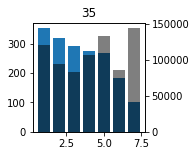

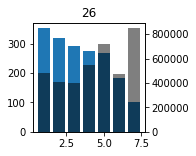

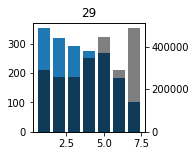

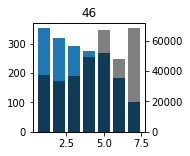

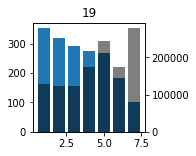

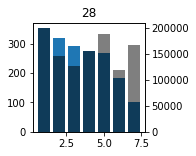

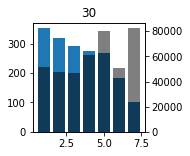

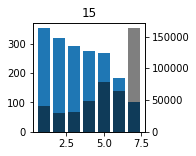

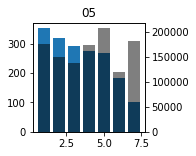

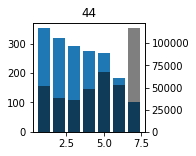

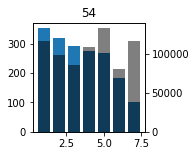

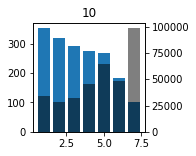

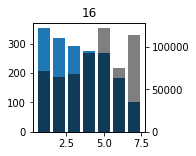

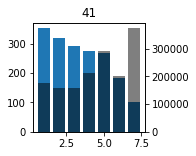

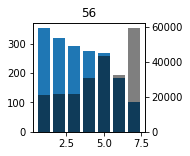

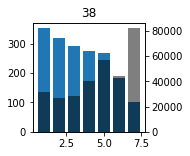

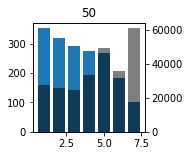

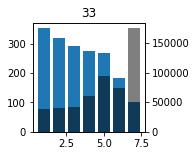

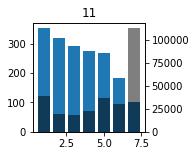

In [495]:
states = list(demo_df['state_fips'].unique())
labels = list(range(1,8))
print('household income for ComScore data')
for state_fips in states:
    fig,ax = plt.subplots(1,1,figsize=(2,2))
    state_demo_df = demo_df[demo_df.state_fips == state]
    state_acs_incomes = state_census_incomes[state_fips]
    ax.bar(labels, state_demo_df['household_income'].value_counts().drop(8).values)
    ax.set_title(state_fips)
    ax2 = ax.twinx()
    ax2.bar(labels, state_acs_incomes, 
       label='ACS',
       alpha=0.5, color=c_acs)


## Race

### Country of origin / hispanic vs non-hispanic

In [276]:
state_census_df.head()

,DP02_0064PE,DP02_0061PE,DP02_0065PE,DP02_0062PE,DP02_0063PE,DP02_0060PE,DP02_0059PE,DP05_0077PE,DP05_0078PE,DP05_0080PE,...,DP03_0054PE,DP03_0055PE,DP03_0056PE,DP03_0057PE,DP03_0058PE,DP03_0059PE,DP03_0060PE,DP03_0061PE,population estimate,state_abbr
state_fips,,,,,,,,,,,,,,,,,,,,,
53,21.7,22.5,12.7,24.0,9.9,5.3,3.8,69.8,3.5,8.0,...,7.9,8.3,12.2,18.1,13.5,16.4,7.1,7.3,7169967.0,WA
08,24.8,21.6,14.6,21.8,8.4,5.2,3.6,68.6,3.9,3.0,...,8.0,8.6,12.6,18.1,13.5,16.2,7.0,7.1,5436519.0,CO
34,23.4,27.9,14.7,16.6,6.5,5.7,5.1,56.1,12.7,9.4,...,7.7,7.3,10.1,15.3,12.2,17.4,9.3,11.9,8960161.0,NJ
17,20.5,26.3,13.0,20.9,7.9,6.3,5.2,61.9,14.1,5.2,...,9.3,8.8,12.3,17.4,12.7,15.0,6.5,6.9,12854526.0,IL
06,20.4,20.6,12.2,21.5,7.8,7.8,9.7,37.9,5.5,13.9,...,8.6,8.3,11.4,16.3,12.2,15.7,7.8,9.7,38982847.0,CA


some stuff from before...

## Create aggregates from comScore demographics

In [207]:
state_df = (pd.melt(demo_df,
       id_vars=['state_fips'],
       value_vars=[
           'hoh_most_education', 'racial_background',
           'household_income', 'country_of_origin'
       ],
       value_name='val',
       var_name='var_name').groupby(['state_fips', 'var_name', 'val'])).val.agg(['count'])
state_df.head(20)

count
state_fips var_name           val       
01         country_of_origin  0.0   1442
                              1.0     83
           hoh_most_education 1.0     25
                              2.0    447
                              3.0    304
                              4.0    192
                              5.0     32
           household_income   1.0    421
                              2.0    339
                              3.0    270
                              4.0     97
                              5.0    156
                              6.0    133
                              7.0     57
                              8.0     52
           racial_background  1.0    927
                              2.0    410
                              3.0     37
                              5.0    151
02         country_of_origin  0.0    148

In [43]:
(state_df
 .groupby(['state_fips', 'var_name'])
 .agg({'count': np.sum}))

count
state_fips var_name                 
01         hoh_most_education   1000
           racial_background    1525
02         hoh_most_education     98
           racial_background     167
04         hoh_most_education    901
...                              ...
54         racial_background     599
55         hoh_most_education    970
           racial_background    1451
56         hoh_most_education     86
           racial_background     134

[102 rows x 1 columns]

In [44]:
state_vars = (state_df.merge(state_df
 .groupby(['state_fips', 'var_name'])
 .agg({'count': np.sum}), 
            how='left',
            right_index=True,
            left_on=['state_fips', 'var_name'])
 .assign(pct=lambda x: x.count_x/x.count_y)
).rename(columns={'count_x': 'count', 'count_y': 'total'})

In [45]:
state_vars

count  total       pct
state_fips var_name           val                        
01         hoh_most_education 1.0     25   1000  0.025000
                              2.0    447   1000  0.447000
                              3.0    304   1000  0.304000
                              4.0    192   1000  0.192000
                              5.0     32   1000  0.032000
...                                  ...    ...       ...
56         hoh_most_education 5.0      3     86  0.034884
           racial_background  1.0    102    134  0.761194
                              2.0     11    134  0.082090
                              3.0      3    134  0.022388
                              5.0     18    134  0.134328

[458 rows x 3 columns]

In [117]:
state_vars.to_csv('../output/state_census_distributions.csv')